In [ ]:
"""hey there, so I have a bunch of code writtent in python/ pytorch. it loads data from a zipfile, reorganizes the data by moving 5 images from each class in the train set into the valid set, and another 5 into the test set. Then analyzes the data with matplotlib (several graphs). Then it transforms the images and uses matplotlib again to provide a few  example pictures from the training set. nest it defines a function to compute the average f1 score and aanother function to compute accuracy. After that it logs the user into wand be. Then it starts a large optuna objective function, where the user has otuna suggest hyperparameters. within the objective function it also loads the model and trains it, providing the accuracy, loss, and f1 score at each ecpoch. Next outside of the objective function, it creates the optuna study and finishes the wand b log. finally it has three def functions and it has it return: the top5 accuracy, the accuracy per each class, and the f1 scor per each class."""

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from IPython.display import clear_output
import wandb
import optuna
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import time
import shutil

In [ ]:
!unzip '/content/drive/MyDrive/DC5.zip' -d '/content/dogata'

clear_output()

#Added the breed "Samoyed"
#Corrected American Spaniel folder name- caused problems when splitting the data
#Modified English bulldog (The initial data mixed pictures of english bulldogs with french bulldogs)
#Modified the Boston Terrier. Initial data also contained images of french bulldogs (ears are the main visual difference)

In [ ]:
train_dir = "/content/dogata/DC2/train"
val_dir = "/content/dogata/DC2/valid"
test_dir = "/content/dogata/DC2/test"


In [ ]:
#Deterministic code
###import random (If you want to randomize the images transferred)
# define your directories
root_dir = "/content/dogata/DC2"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
valid_dir = os.path.join(root_dir, "valid")

# get the list of classes
classes = os.listdir(train_dir)

# for each class, move 5 images from train to test and valid
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)

    # create the class directory in test and valid if it does not exist
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)

    # get a list of images in the train directory for this class
    images = sorted(os.listdir(train_class_dir))
    ###random.shuffle(images) (If you want to randomize the images transferred)
    # select the first 10 images to move
    images_to_move = images[:10]

    # move 5 images to test
    for i, image in enumerate(images_to_move[:5]):
        new_name = f"{class_name}_test_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(test_class_dir, new_name))

    # move 5 images to valid
    for i, image in enumerate(images_to_move[5:]):
        new_name = f"{class_name}_valid_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(valid_class_dir, new_name))


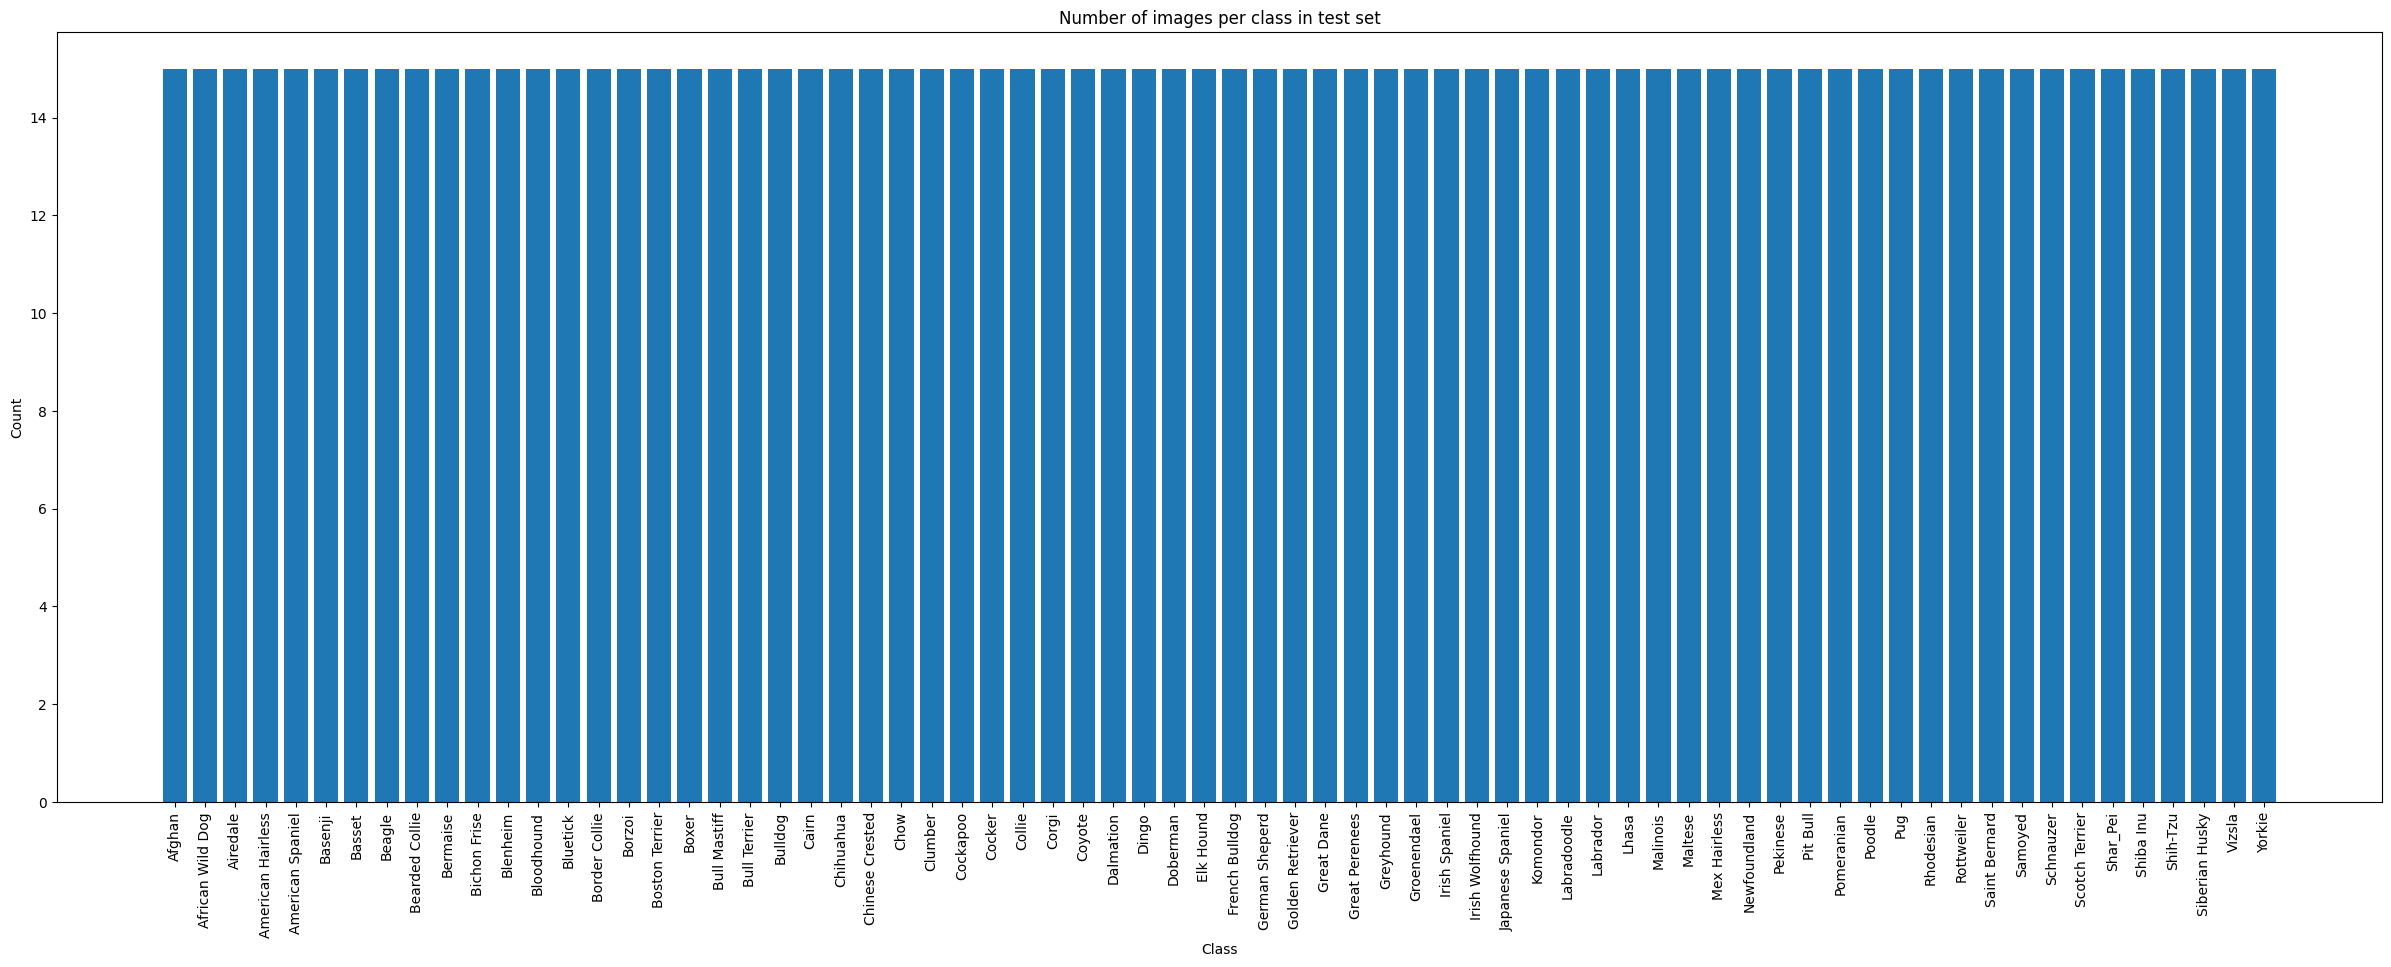

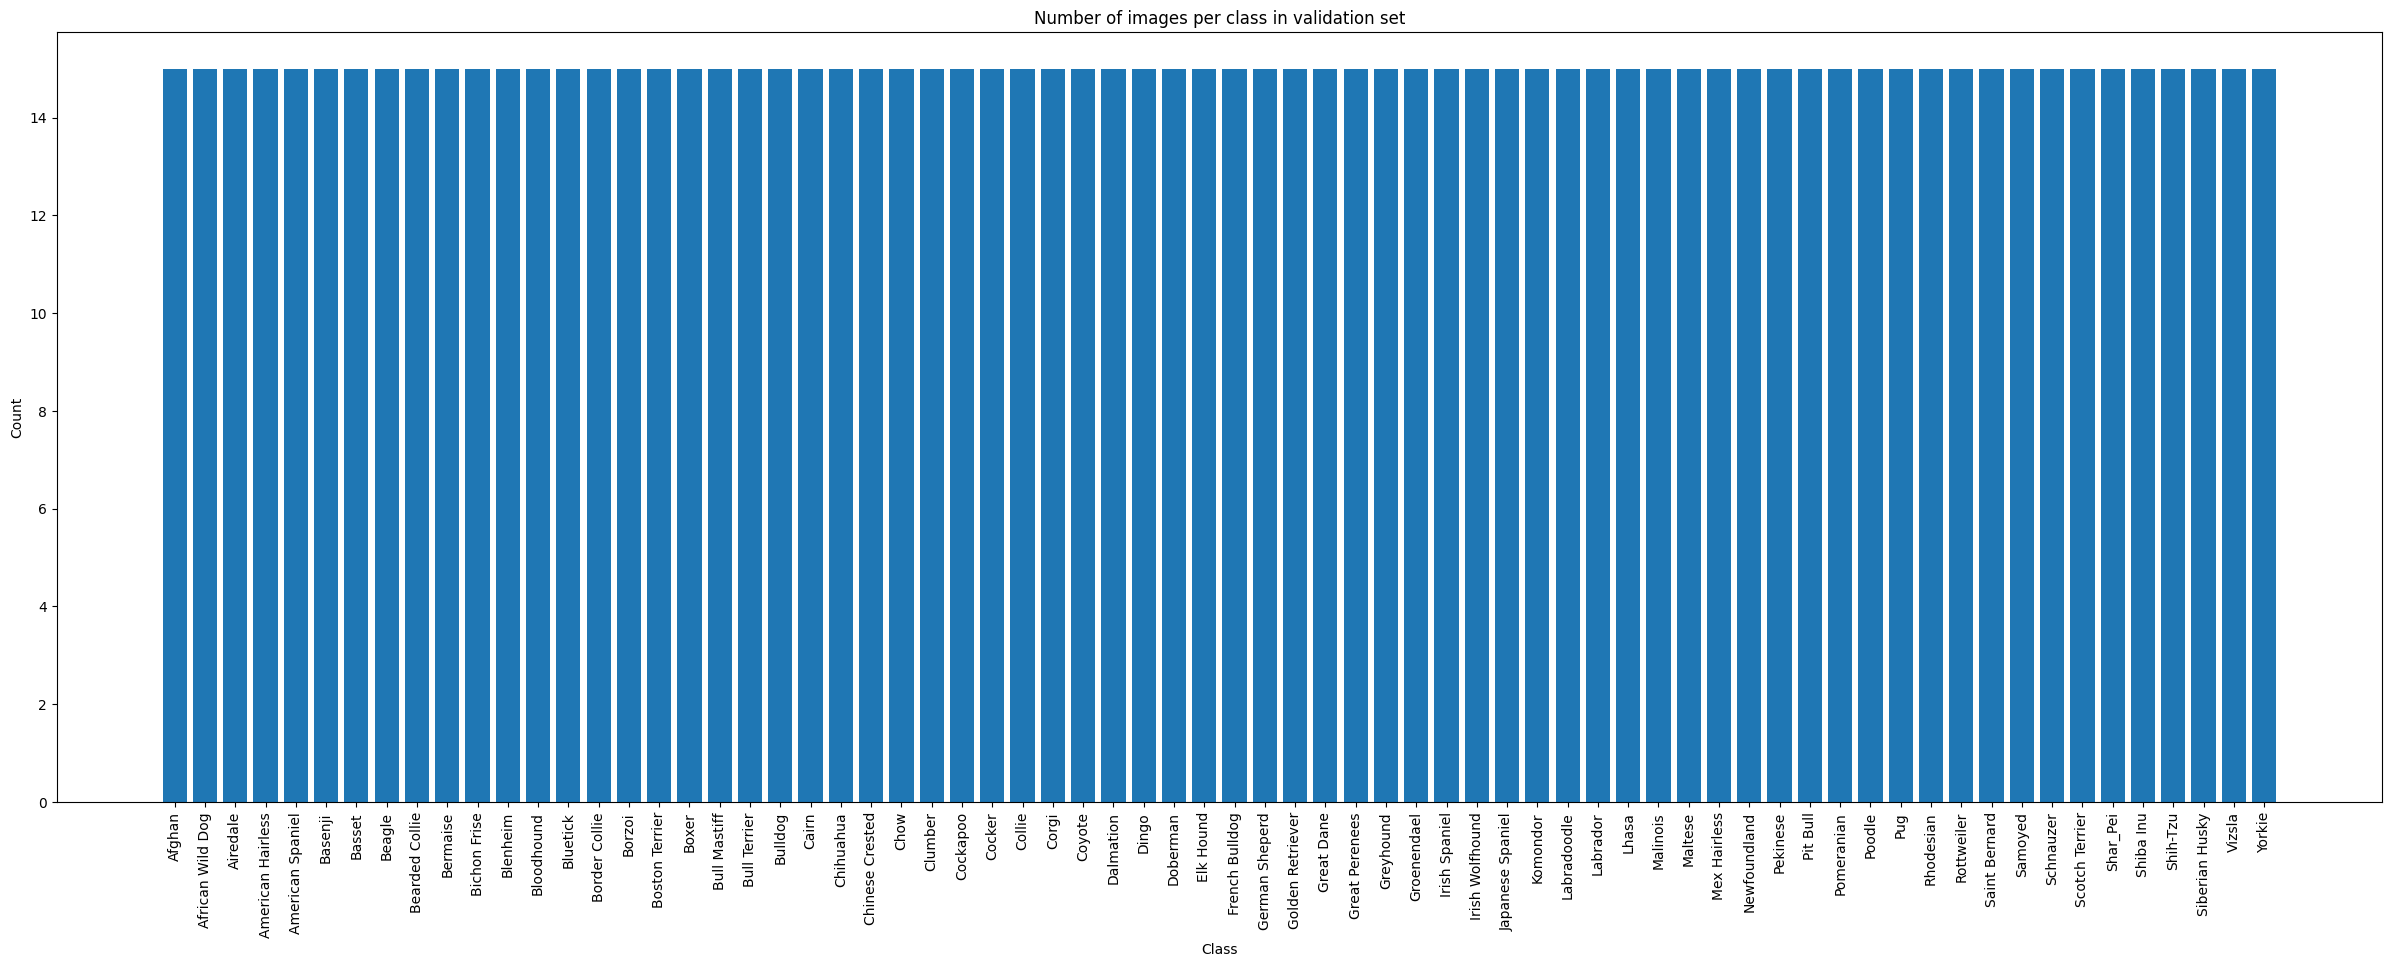

In [ ]:

def plot_histogram(directory, title):
    classes = os.listdir(directory)
    counts = [len(os.listdir(os.path.join(directory, cls))) for cls in classes]
    df = pd.DataFrame(list(zip(classes, counts)), columns=['Class', 'Count'])
    df = df.sort_values('Class')
    plt.figure(figsize=(30,10))
    plt.bar(df['Class'], df['Count'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation='vertical')
    plt.show()

# Now you can call the function for each directory
plot_histogram(test_dir, 'Number of images per class in test set')
plot_histogram(valid_dir, 'Number of images per class in validation set')


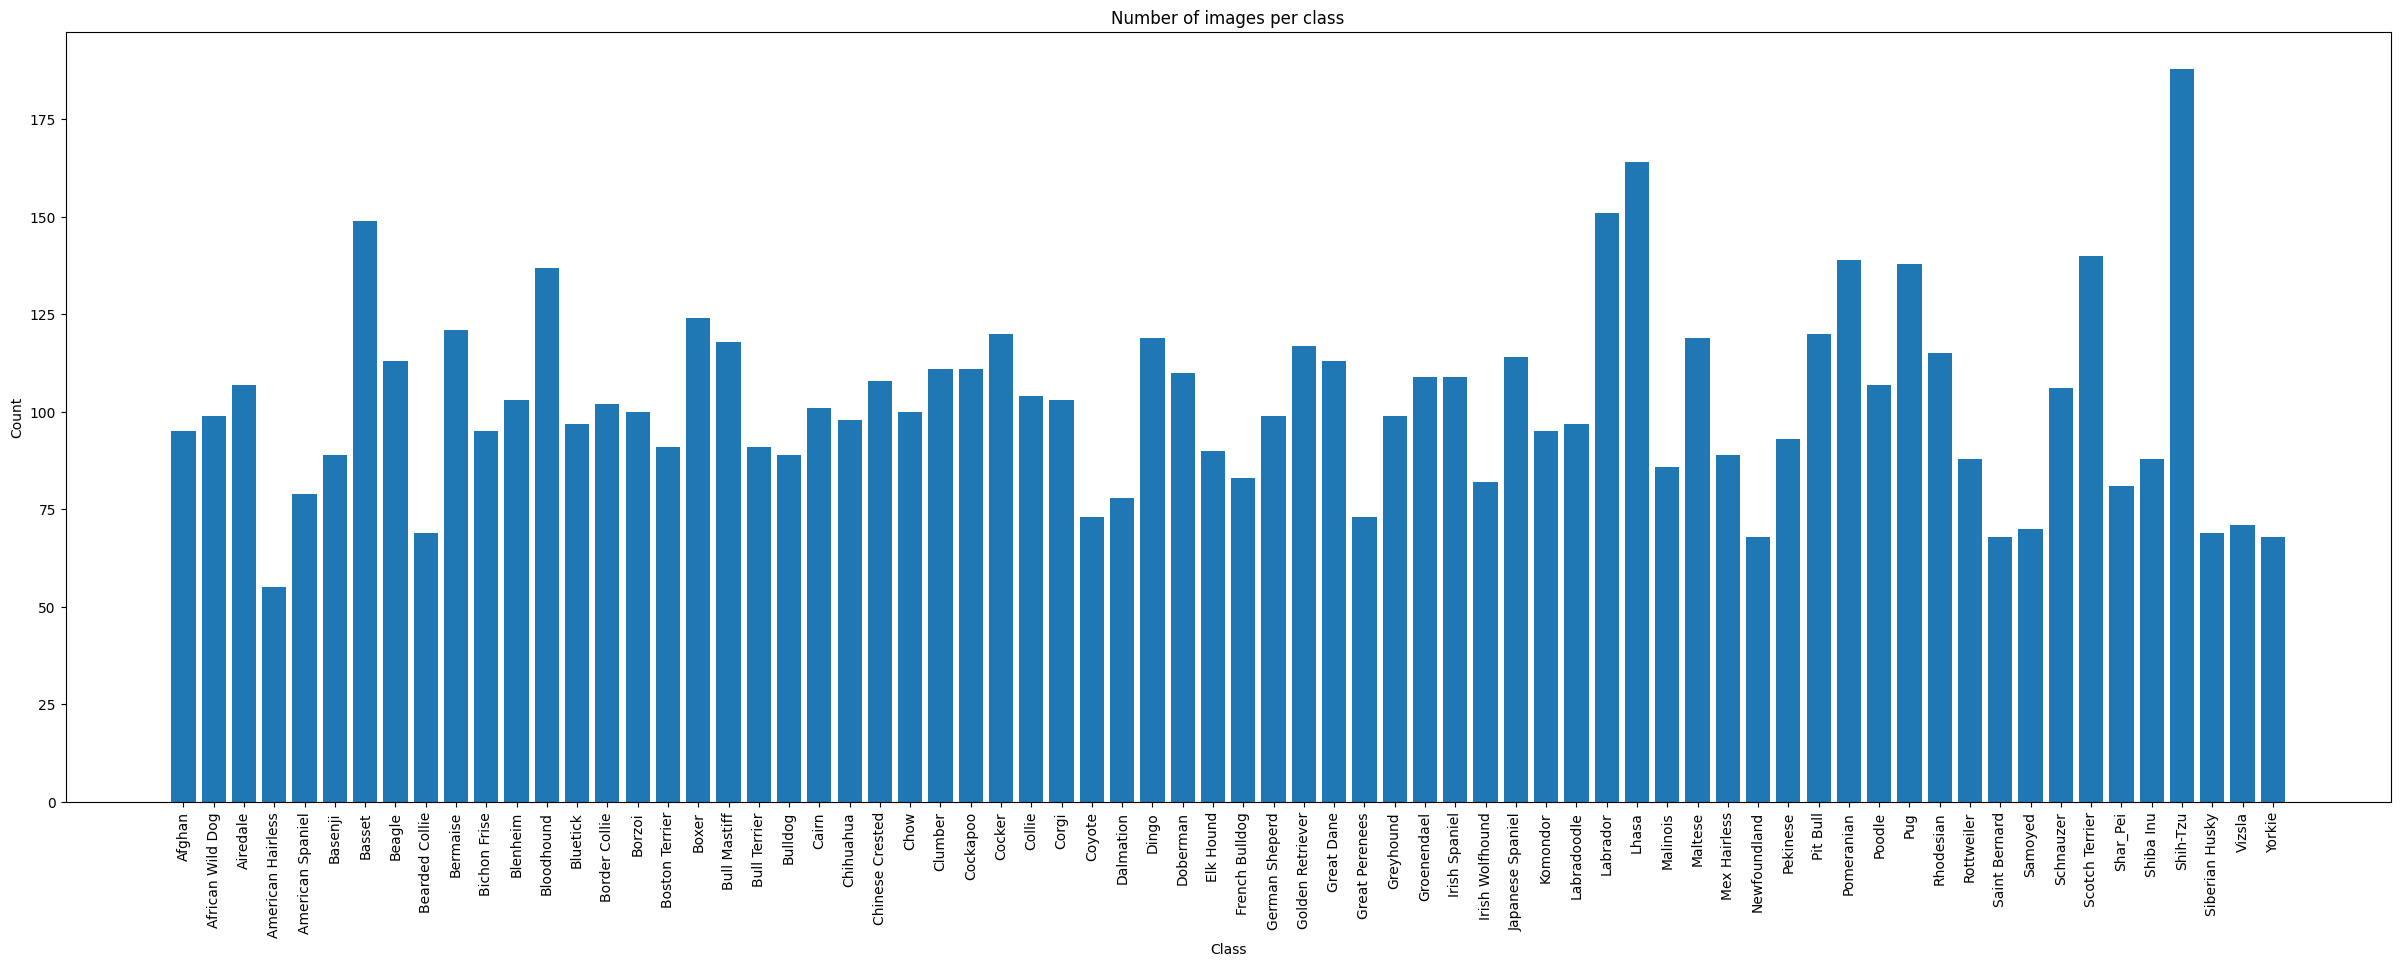

In [ ]:
# Get the list of all classes
classes = os.listdir(train_dir)

# Count the number of images in each class
counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]

# Create a DataFrame
df = pd.DataFrame(list(zip(classes, counts)), columns=['Class', 'Count'])

# Sort the DataFrame by Class
df = df.sort_values('Class')

# Create a histogram
plt.figure(figsize=(30,10))
plt.bar(df['Class'], df['Count'])
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Find the class with the minimum number of images
min_class = min(counts, key=counts.get)
min_count = counts[min_class]

# Find the class with the maximum number of images
max_class = max(counts, key=counts.get)
max_count = counts[max_class]

print(f'The dog class with the lowest number of images is "{min_class}" with {min_count} images.')
print(f'The dog class with the highest number of images is "{max_class}" with {max_count} images.')


import numpy as np

def gini_index(arr):
    # (Warning: This is a simplified version and does not account for zero elements)
    arr = np.array(arr, dtype=np.float32)
    arr = arr / np.sum(arr)
    arr = np.sort(arr)
    index = np.arange(1, arr.shape[0] + 1)
    n = arr.shape[0]
    return ((np.sum((2 * index - n  - 1) * arr)) / n)

counts_values = list(counts.values())
gini = gini_index(counts_values)
print(f"Gini Index: {gini}")

#The imbalance in data is low


The dog class with the lowest number of images is "American Hairless" with 55 images.
The dog class with the highest number of images is "Shih-Tzu" with 188 images.
Gini Index: 0.1275027382054499


In [ ]:
transforms_train = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.CenterCrop((224, 224)),# data augmentation
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    v2.Resize((224, 224), antialias=True),   #must same as here
    v2.CenterCrop((224, 224)),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transforms_test)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
transforms_train = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.CenterCrop((224, 224)),# data augmentation
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    v2.Resize((224, 224), antialias=True),   #must same as here
    v2.CenterCrop((224, 224)),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transforms_test)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
print('Train dataset size:', len(train_dataset))
print('Total classes:', len(train_dataset.classes))  # Use train_dataset as an example
print('Unique classes in train dataset:', len(set(train_dataset.targets)))

print('Validation dataset size:', len(val_dataset))
print('Total classes:', len(val_dataset.classes))  # Use val_dataset as an example
print('Unique classes in validation dataset:', len(set(train_dataset.targets)))

print('Test dataset size:', len(test_dataset))
print('Total classes:', len(test_dataset.classes))  # Use test_dataset as an example
print('Unique classes in test dataset:', len(set(test_dataset.targets)))

class_names = train_dataset.classes
print('Class names:', class_names)



Train dataset size: 7165
Total classes: 70
Unique classes in train dataset: 70
Validation dataset size: 1050
Total classes: 70
Unique classes in validation dataset: 70
Test dataset size: 1050
Total classes: 70
Unique classes in test dataset: 70
Class names: ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', '

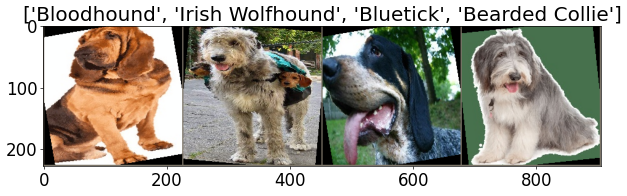

In [ ]:
"""These dataloaders are simply for the purpose of visualizing the data. I will be using different dataloaders in the objective function
for optuna, where batch_size will be a hperparameter catigorical variable."""
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_loader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_cuda = torch.cuda.is_available()

if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available.")

CUDA is available!


In [ ]:
def compute_f1_score(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(inputs)

        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.detach().cpu().numpy())
        pred_labels.extend(predictions.detach().cpu().numpy())

    f1 = f1_score(true_labels, pred_labels, average='macro')
    return f1


def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0.0
    total_examples = 0
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)
    accuracy = correct / total_examples
    return accuracy.item()  # return a Python scalar


In [ ]:
wandb.login()


def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float("lr", 1e-2, 1e-1, log=True)
    num_epochs = trial.suggest_int("num_epochs", 1, 30)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    model_name = "resnet18"
    #there are models that have improved accuracy over resnet18, but I am using this due to its balancce of speed and performance (plus limited training gpu resources)


    wandb.init(
        project="Dog Classification Project",
        config={
            "learning_rate": lr,
            "batch_size": batch_size,
            "model_architecture": model_name,  # Use the model name string here
            "epochs": num_epochs,
      }
  )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load the pre-trained model
    mod = getattr(models, model_name)
    model = mod(pretrained=True)
#print(model)

# Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Unfreeze the last layer, only necessary if you also froze the FC along the tohers
    """for param in model.fc.parameters():
        param.requires_grad = True"""

    # Modify the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 70)


    # Move the model to the device
    model = model.to(device)



    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.0) #Will be leaving the optimizer at 0 momentum, but can be changed



    loss_list = []
    train_acc_list, val_acc_list = [], []
    val_f1_list = []
    overfitting_list = []


    start_time = time.time()
    for epoch in range(num_epochs):

        model = model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)

            loss = F.cross_entropy(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if not batch_idx % 250:
                ### LOGGING
                print(
                    f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                    f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                    f" | Train Loss: {loss:.2f}"
                )
            loss_list.append(loss.item())

        train_f1 = compute_f1_score(model, train_loader)
        val_f1 = compute_f1_score(model, val_loader)
        print(f"Train F1 {train_f1*100:.2f}% | Val F1 {val_f1*100:.2f}%")

        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
        overfitting = train_acc-val_acc
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        overfitting_list.append(overfitting)
        wandb.log({"acc": val_acc, "overfitting": overfitting, "loss": loss, "F1 Macro": val_f1 })

    test_acc = compute_accuracy(model, test_loader)
    print(f"Test Acc {test_acc*100:.2f}%")
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    wandb.finish()
    return max(val_f1_list)

study = optuna.create_study(
    direction="maximize",
    study_name="Hot Dog",
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective, n_trials=100)



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
[I 2024-03-28 02:12:33,002] A new study created in memory with name: Hot Dog
wandb: Currently logged in as: chrismontes22. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch: 001/010 | Batch 000/448 | Train Loss: 4.32
Epoch: 001/010 | Batch 250/448 | Train Loss: 1.15
Train F1 85.49% | Val F1 86.99%
Train Acc 85.48% | Val Acc 86.95%
Epoch: 002/010 | Batch 000/448 | Train Loss: 0.86
Epoch: 002/010 | Batch 250/448 | Train Loss: 0.87
Train F1 89.59% | Val F1 89.46%
Train Acc 89.41% | Val Acc 89.71%
Epoch: 003/010 | Batch 000/448 | Train Loss: 0.52
Epoch: 003/010 | Batch 250/448 | Train Loss: 0.58
Train F1 91.57% | Val F1 91.71%
Train Acc 91.40% | Val Acc 91.62%
Epoch: 004/010 | Batch 000/448 | Train Loss: 0.36
Epoch: 004/010 | Batch 250/448 | Train Loss: 0.61
Train F1 92.38% | Val F1 91.63%
Train Acc 92.20% | Val Acc 91.62%
Epoch: 005/010 | Batch 000/448 | Train Loss: 0.34
Epoch: 005/010 | Batch 250/448 | Train Loss: 0.37
Train F1 92.77% | Val F1 91.98%
Train Acc 92.62% | Val Acc 92.10%
Epoch: 006/010 | Batch 000/448 | Train Loss: 0.71
Epoch: 006/010 | Batch 250/448 | Train Loss: 0.75
Train F1 93.70% | Val F1 92.40%
Train Acc 93.79% | Val Acc 92.48%
Epoc

F1 Macro,▁▄▇▇▇█▇▇█▇
acc,▁▄▇▇▇█▇▇██
loss,▇█▄▁▃▂▄▂▁▄
overfitting,▁▃▃▄▄▆▇█▇▇
F1 Macro,0.92219
acc,0.92381
loss,0.55233
overfitting,0.02232


[I 2024-03-28 02:31:22,434] Trial 0 finished with value: 0.9271418283236971 and parameters: {'lr': 0.018314002408992183, 'num_epochs': 10, 'batch_size': 16}. Best is trial 0 with value: 0.9271418283236971.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/023 | Batch 000/448 | Train Loss: 4.32
Epoch: 001/023 | Batch 250/448 | Train Loss: 1.06
Train F1 86.18% | Val F1 86.93%
Train Acc 85.96% | Val Acc 86.86%
Epoch: 002/023 | Batch 000/448 | Train Loss: 0.80
Epoch: 002/023 | Batch 250/448 | Train Loss: 0.84
Train F1 89.85% | Val F1 89.55%
Train Acc 89.77% | Val Acc 89.81%
Epoch: 003/023 | Batch 000/448 | Train Loss: 0.49
Epoch: 003/023 | Batch 250/448 | Train Loss: 0.56
Train F1 91.74% | Val F1 91.61%
Train Acc 91.65% | Val Acc 91.52%
Epoch: 004/023 | Batch 000/448 | Train Loss: 0.33
Epoch: 004/023 | Batch 250/448 | Train Loss: 0.59
Train F1 92.58% | Val F1 91.71%
Train Acc 92.45% | Val Acc 91.71%
Epoch: 005/023 | Batch 000/448 | Train Loss: 0.32
Epoch: 005/023 | Batch 250/448 | Train Loss: 0.35
Train F1 92.95% | Val F1 92.08%
Train Acc 92.67% | Val Acc 92.19%
Epoch: 006/023 | Batch 000/448 | Train Loss: 0.69
Epoch: 006/023 | Batch 250/448 | Train Loss: 0.73
Train F1 93.91% | Val F1 92.50%
Train Acc 94.11% | Val Acc 92.57%
Epoc

F1 Macro,▁▄▆▆▆▇▇▆▇▆█▇▇▇▇▇▇▇▇▇▇▇▇
acc,▁▄▆▆▆▇▇▆▇▆█▇▇▇▇▇▇▇▇▇▇▇▇
loss,▇█▄▁▄▂▄▂▂▄▁▃▃▃▂▂▄▂▁▁▁▂▅
overfitting,▁▂▂▃▃▄▅▆▆▅▄▆▆▆▇▇▇██▇███
F1 Macro,0.93101
acc,0.93143
loss,0.64372
overfitting,0.04373


[I 2024-03-28 03:14:13,976] Trial 1 finished with value: 0.9377033977375626 and parameters: {'lr': 0.02022662315853213, 'num_epochs': 23, 'batch_size': 16}. Best is trial 1 with value: 0.9377033977375626.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 001/026 | Batch 000/112 | Train Loss: 4.42
Train F1 59.89% | Val F1 59.95%
Train Acc 64.76% | Val Acc 62.86%
Epoch: 002/026 | Batch 000/112 | Train Loss: 2.02
Train F1 80.42% | Val F1 81.86%
Train Acc 81.35% | Val Acc 82.86%
Epoch: 003/026 | Batch 000/112 | Train Loss: 1.61
Train F1 86.30% | Val F1 88.10%
Train Acc 86.63% | Val Acc 88.29%
Epoch: 004/026 | Batch 000/112 | Train Loss: 1.02
Train F1 87.82% | Val F1 89.28%
Train Acc 88.32% | Val Acc 89.43%
Epoch: 005/026 | Batch 000/112 | Train Loss: 0.79
Train F1 89.48% | Val F1 91.14%
Train Acc 89.06% | Val Acc 91.14%
Epoch: 006/026 | Batch 000/112 | Train Loss: 0.76
Train F1 90.21% | Val F1 91.36%
Train Acc 90.24% | Val Acc 91.43%
Epoch: 007/026 | Batch 000/112 | Train Loss: 0.63
Train F1 90.85% | Val F1 91.35%
Train Acc 90.76% | Val Acc 91.33%
Epoch: 008/026 | Batch 000/112 | Train Loss: 0.71
Train F1 91.21% | Val F1 91.80%
Train Acc 91.04% | Val Acc 91.81%
Epoch: 009/026 | Batch 000/112 | Train Loss: 0.46
Train F1 91.72% | Val 

In [ ]:
wandb.finish()

F1 Macro,▁▄▇▆▆▆▇█
acc,▁▄▆▆▆▆██
loss,▁▅▅▆▅▃▄█
overfitting,█▅▁▁▂█▆▇
F1 Macro,0.00754
acc,0.01143
loss,4.5956
overfitting,0.00043


In [ ]:
def compute_top5_accuracy(model, dataloader):
    model.eval()
    correct = 0.0
    total_examples = 0
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        top5_preds = torch.topk(logits, 5, dim=1)[1]
        correct += torch.sum(top5_preds == labels.view(-1, 1).expand_as(top5_preds)).item()
        total_examples += len(labels)
    top5_accuracy = correct / total_examples
    return top5_accuracy
test_top5_acc = compute_top5_accuracy(model, test_loader)
print(f"Test Top-5 Acc: {test_top5_acc*100:.2f}%")


Test Top-5 Acc: 100.00%


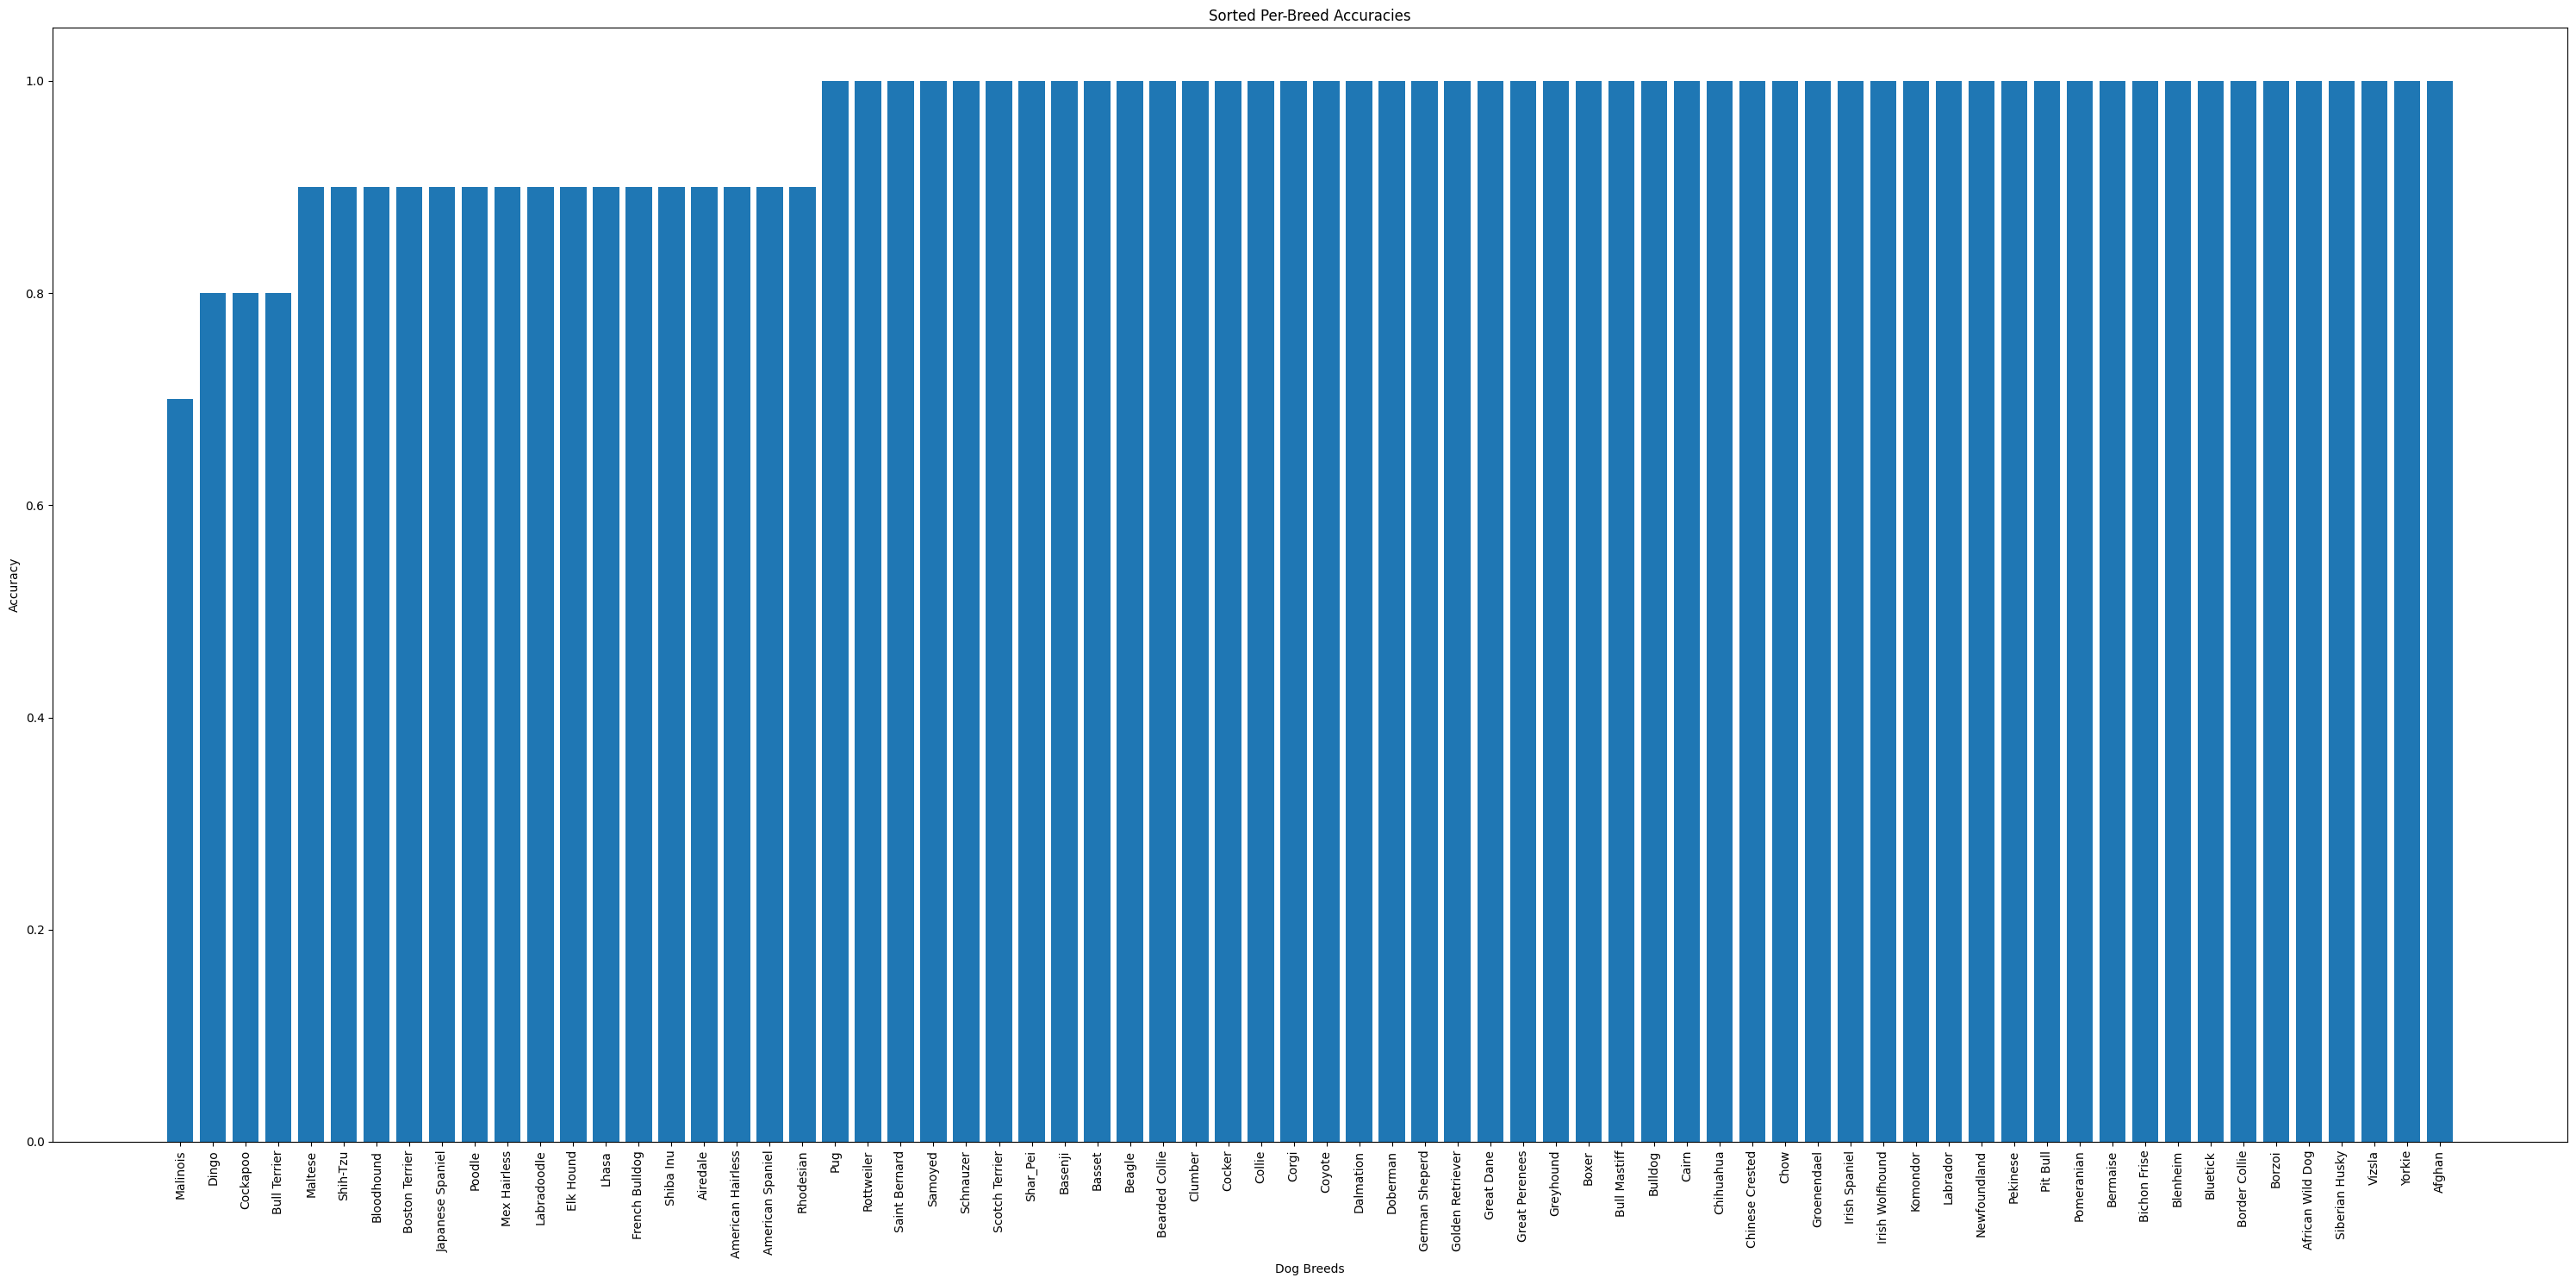

Test Acc for class Malinois: 70.00%
Test Acc for class Dingo: 80.00%
Test Acc for class Cockapoo: 80.00%
Test Acc for class Bull Terrier: 80.00%
Test Acc for class Maltese: 90.00%
Test Acc for class Shih-Tzu: 90.00%
Test Acc for class Bloodhound: 90.00%
Test Acc for class Boston Terrier: 90.00%
Test Acc for class Japanese Spaniel: 90.00%
Test Acc for class Poodle: 90.00%
Test Acc for class Mex Hairless: 90.00%
Test Acc for class Labradoodle: 90.00%
Test Acc for class Elk Hound: 90.00%
Test Acc for class Lhasa: 90.00%
Test Acc for class French Bulldog: 90.00%
Test Acc for class Shiba Inu: 90.00%
Test Acc for class Airedale: 90.00%
Test Acc for class American Hairless: 90.00%
Test Acc for class American Spaniel: 90.00%
Test Acc for class Rhodesian: 90.00%
Test Acc for class Pug: 100.00%
Test Acc for class Rottweiler: 100.00%
Test Acc for class Saint Bernard: 100.00%
Test Acc for class Samoyed: 100.00%
Test Acc for class Schnauzer: 100.00%
Test Acc for class Scotch Terrier: 100.00%
Test A

In [ ]:
def compute_per_class_accuracy(model, dataloader, num_classes):
    model.eval()
    correct_per_class = [0.0] * num_classes
    total_per_class = [0.0] * num_classes
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        for i in range(num_classes):
            correct_per_class[i] += torch.sum((predictions == i) & (labels == i)).item()
            total_per_class[i] += torch.sum(labels == i).item()
    accuracy_per_class = [correct / total if total > 0 else 0 for correct, total in zip(correct_per_class, total_per_class)]
    return accuracy_per_class  # return a list of Python scalars
class_names = train_dataset.classes

# Compute per-class accuracy for the test set after training
test_per_class_acc = compute_per_class_accuracy(model, test_loader, num_classes=len(train_dataset.classes))

sorted_indices = np.argsort(test_per_class_acc)
sorted_accuracies = np.array(test_per_class_acc)[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]

# Create a sorted bar plot for accuracies
plt.figure(figsize=(30, 15))  # Adjust as needed
plt.bar(sorted_class_names, sorted_accuracies)
plt.xlabel('Dog Breeds')
plt.ylabel('Accuracy')
plt.title('Sorted Per-Breed Accuracies')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
plt.tight_layout()  # Ensure that labels fit into the figure area
plt.show()
# Get the class names


for i, acc in enumerate(sorted_accuracies):
    print(f"Test Acc for class {sorted_class_names[i]}: {acc*100:.2f}%")

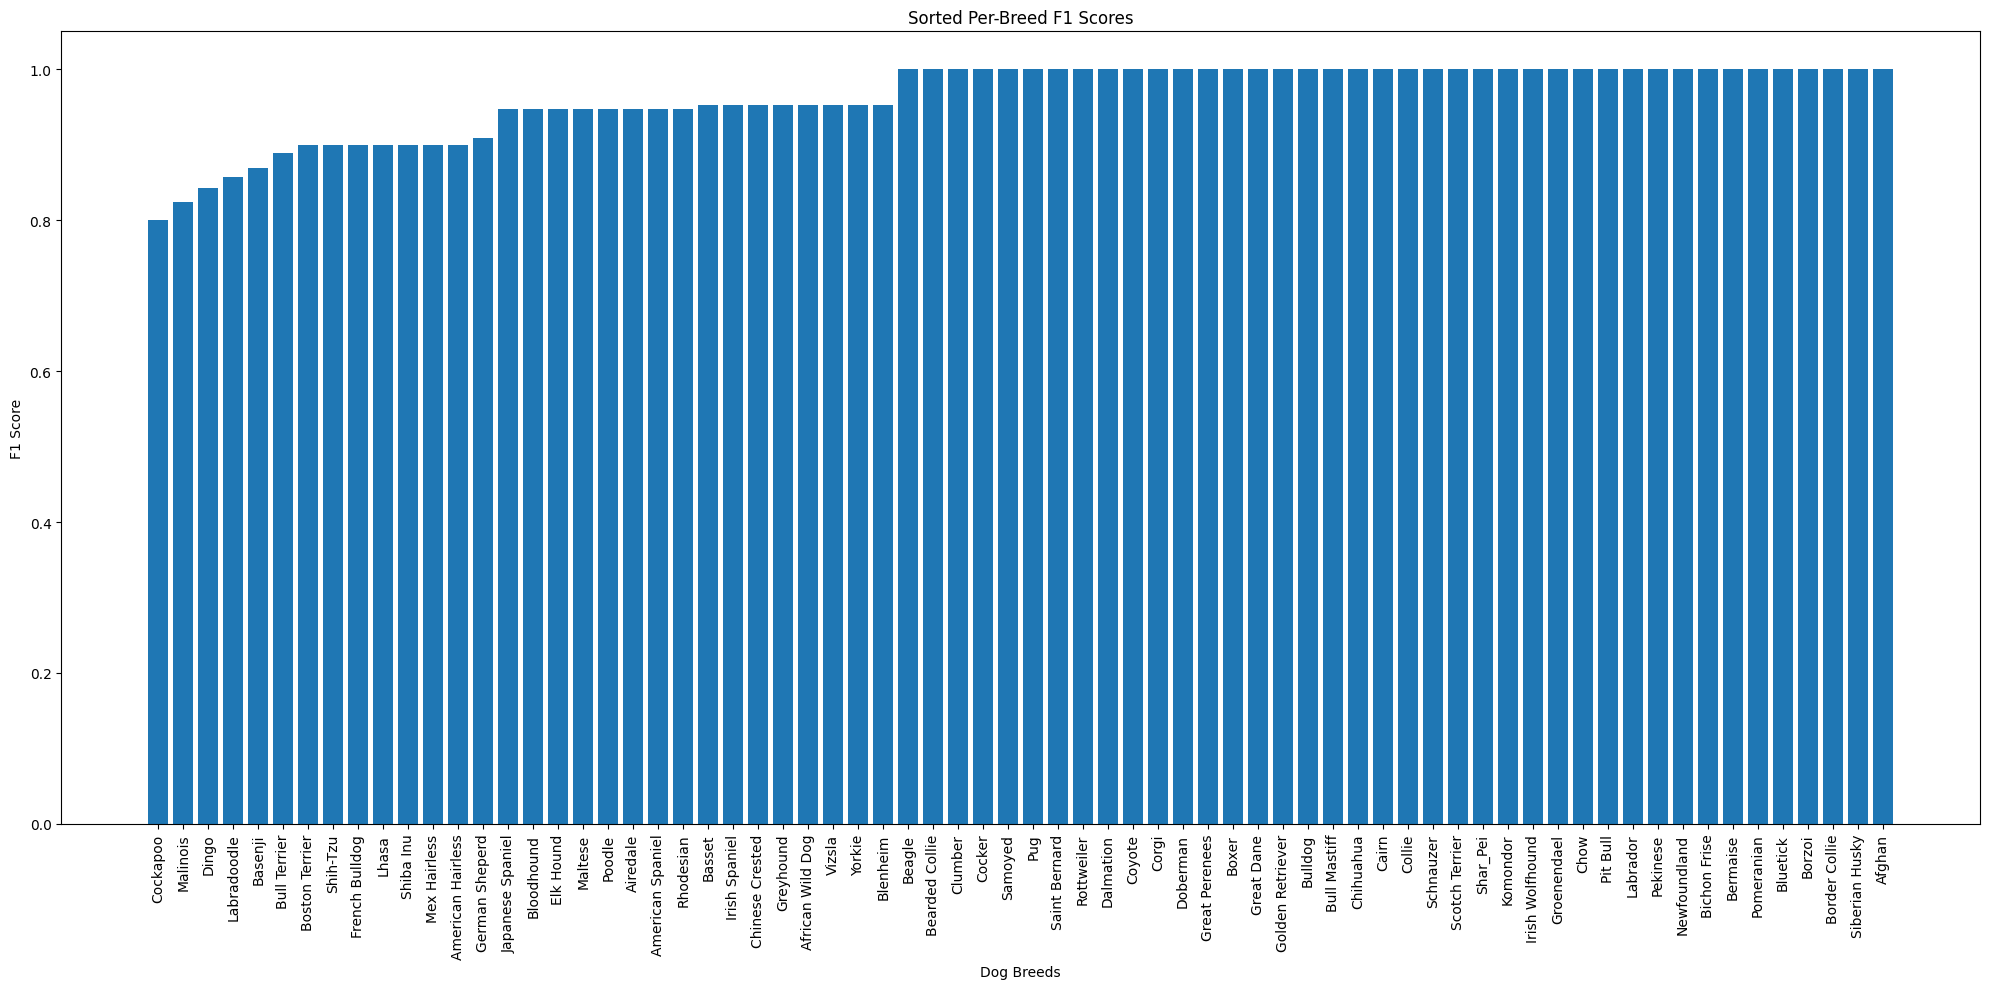

F1 Score for Cockapoo: 0.80
F1 Score for Malinois: 0.82
F1 Score for Dingo: 0.84
F1 Score for Labradoodle: 0.86
F1 Score for Basenji: 0.87
F1 Score for Bull Terrier: 0.89
F1 Score for Boston Terrier: 0.90
F1 Score for Shih-Tzu: 0.90
F1 Score for French Bulldog: 0.90
F1 Score for Lhasa: 0.90
F1 Score for Shiba Inu: 0.90
F1 Score for Mex Hairless: 0.90
F1 Score for American Hairless: 0.90
F1 Score for German Sheperd: 0.91
F1 Score for Japanese Spaniel: 0.95
F1 Score for Bloodhound: 0.95
F1 Score for Elk Hound: 0.95
F1 Score for Maltese: 0.95
F1 Score for Poodle: 0.95
F1 Score for Airedale: 0.95
F1 Score for American Spaniel: 0.95
F1 Score for Rhodesian: 0.95
F1 Score for Basset: 0.95
F1 Score for Irish Spaniel: 0.95
F1 Score for Chinese Crested: 0.95
F1 Score for Greyhound: 0.95
F1 Score for African Wild Dog: 0.95
F1 Score for Vizsla: 0.95
F1 Score for Yorkie: 0.95
F1 Score for Blenheim: 0.95
F1 Score for Beagle: 1.00
F1 Score for Bearded Collie: 1.00
F1 Score for Clumber: 1.00
F1 Score 

In [ ]:


def compute_f1_score_per_class(model, dataloader, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.detach().cpu().numpy())
        predicted_labels.extend(predictions.detach().cpu().numpy())
    f1_scores = f1_score(true_labels, predicted_labels, average=None)  # 'None' for scores for each class
    return f1_scores  # return a list of Python scalars
# Compute F1 score for each class in the test set after training
# Compute F1 score for each class in the test set after training
# Compute F1 score for each class in the test set after training
test_f1_scores = compute_f1_score_per_class(model, test_loader, num_classes=len(train_dataset.classes))
class_names = train_dataset.classes  # Assuming class_names are your dog breeds

# Sort the scores and corresponding class names
sorted_indices = np.argsort(test_f1_scores)
sorted_f1_scores = test_f1_scores[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]
# Create a sorted bar plot for F1 scores
plt.figure(figsize=(20, 10))  # Adjust as needed
plt.bar(sorted_class_names, sorted_f1_scores)
plt.xlabel('Dog Breeds')
plt.ylabel('F1 Score')
plt.title('Sorted Per-Breed F1 Scores')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
plt.tight_layout()  # Ensure that labels fit into the figure area
plt.show()

class_names = train_dataset.classes  # Assuming class_names are your dog breeds
for i, f1 in enumerate(sorted_f1_scores):
    print(f"F1 Score for {sorted_class_names[i]}: {f1:.2f}")


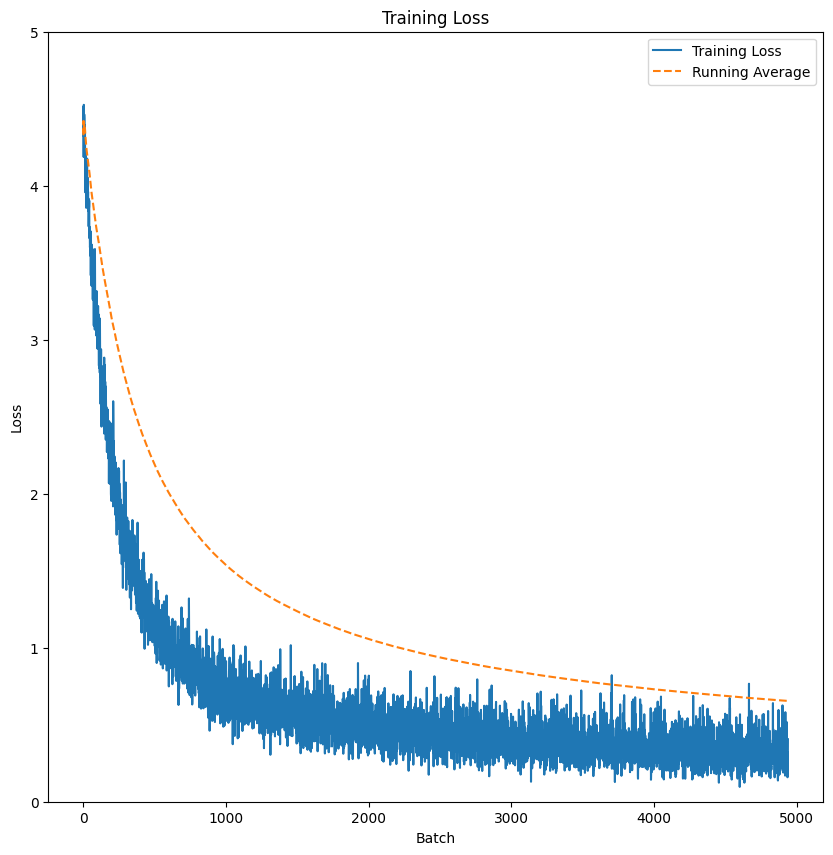

In [ ]:
# Calculate the running average
running_avg_loss = np.cumsum(loss_list) / np.arange(1, len(loss_list) + 1)

# Plot the training loss and the running average
plt.figure(figsize=(10, 10))
plt.plot(loss_list, label='Training Loss')
plt.plot(running_avg_loss, label='Running Average', linestyle='--')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.legend()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()


In [ ]:
"""import shutil

folder_path = "/content/dogata" # Replace with the actual folder path

shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' has been deleted successfully.")
"""